In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
from TomTomUnifiedModel import aggregation_functionTomTom
from WeatherData import aggregation_functionWeather
import os
import sys
from datetime import datetime
from calendar import day_abbr, month_abbr, mdays
from scipy.stats import skew
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew
import seaborn as sns
import numpy as np
import utils

In [2]:
#Dataframe with Greek Holidays
holidays_dict = {'ds': ['2019-01-01',"2019-01-06", "2019-03-25", "2019-04-26",  "2019-04-29", "2019-05-01", "2019-06-17", "2019-08-15", "2019-10-28", "2019-12-25", "2019-12-26"], 'holiday' : ["New Year's Day", "Epiphany", "Independence Day", "Orthodox Good Friday", "Orthodox Easter Monday", "Labour Day", "Orthodox Whit Monday", "Assumption", "Ochi Day", "Christmas Day", "Boxing Day"] }
holidays_data = pd.DataFrame.from_dict(holidays_dict)

In [3]:
holidays_data

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-01-06,Epiphany
2,2019-03-25,Independence Day
3,2019-04-26,Orthodox Good Friday
4,2019-04-29,Orthodox Easter Monday
5,2019-05-01,Labour Day
6,2019-06-17,Orthodox Whit Monday
7,2019-08-15,Assumption
8,2019-10-28,Ochi Day
9,2019-12-25,Christmas Day


In [4]:
#Aggregation function returns the data aggregated according to a value
data = aggregation_functionTomTom(1440)
data

,timestamp,cs_Gate 10A - Entry,cs_Gate 10A - Exit,cs_Gate 16 - Entrance,cs_Gate 16 - Exit
0,2018-04-28,164.0,139.0,416.0,423.0
1,2018-04-29,88.0,76.0,381.0,389.0
2,2018-04-30,707.0,663.0,258.0,293.0
3,2018-05-01,40.0,40.0,9.0,20.0
4,2018-05-02,604.0,568.0,430.0,456.0
...,...,...,...,...,...
643,2020-01-31,980.0,882.0,730.0,832.0
644,2020-02-01,249.0,217.0,296.0,325.0
645,2020-02-02,153.0,159.0,13.0,23.0
646,2020-02-03,1021.0,914.0,762.0,865.0


In [5]:
#We only work with one location at a time
i = 4
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(data['timestamp'], format = '%Y-%m-%d %H:%M:%S')
df['volume'] = data.iloc[:, i]
df

,timestamp,volume
0,2018-04-28,423.0
1,2018-04-29,389.0
2,2018-04-30,293.0
3,2018-05-01,20.0
4,2018-05-02,456.0
...,...,...
643,2020-01-31,832.0
644,2020-02-01,325.0
645,2020-02-02,23.0
646,2020-02-03,865.0


In [6]:
df = df.set_index('timestamp')

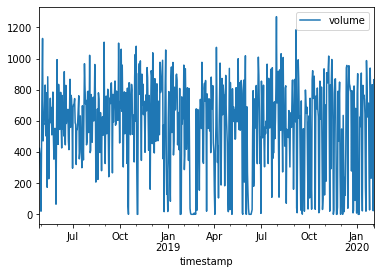

In [7]:
pd.plotting.register_matplotlib_converters()
df.plot()

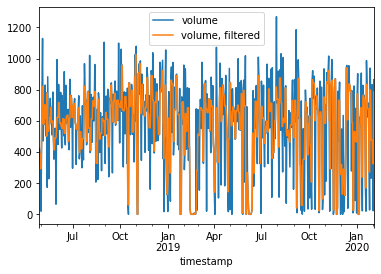

In [8]:
import utils
import scipy
from scipy.signal import medfilt
dfc = df.copy()
dfc.loc[:, 'volume, filtered'] = medfilt(dfc['volume'])
dfc.plot()


In [9]:
dfc.isnull().sum()

volume              0
volume, filtered    0
dtype: int64

In [10]:
df[df.isna().any(axis = 1)]

,volume
timestamp,


In [11]:
current_speed = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).mean()
q25 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.25)
q75 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.75)

In [12]:
ndays_m = mdays.copy()
ndays_m[2] = 29

Text(0.5, 1.0, 'Volume')

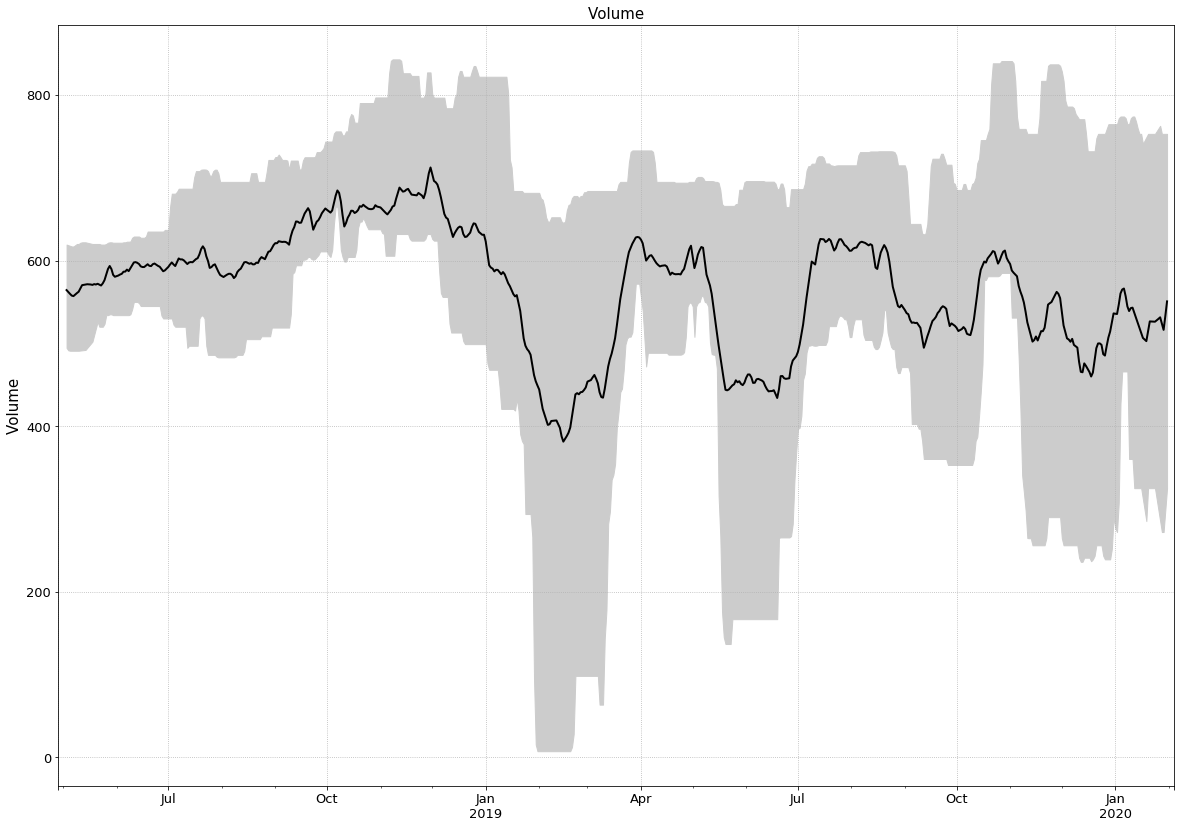

In [13]:
f, ax = plt.subplots(figsize=(20,14)) 

current_speed.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(current_speed.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

#ax.set_xticks(ndays_m)
#ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

ax.set_xlabel('', fontsize=15)

ax.set_ylabel('Volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Volume', fontsize=15)

In [14]:
hour_week = dfc.loc[:, ['volume, filtered']].copy()
hour_week.loc[:, 'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour
hour_week = hour_week.groupby(['day_of_week', 'hour']).mean().unstack()
hour_week.columns = hour_week.columns.droplevel(0)

In [15]:
hour_week

hour,0
day_of_week,
0,547.387097
1,625.333333
2,605.695652
3,635.673913
4,630.119565
5,480.580645
6,447.709677


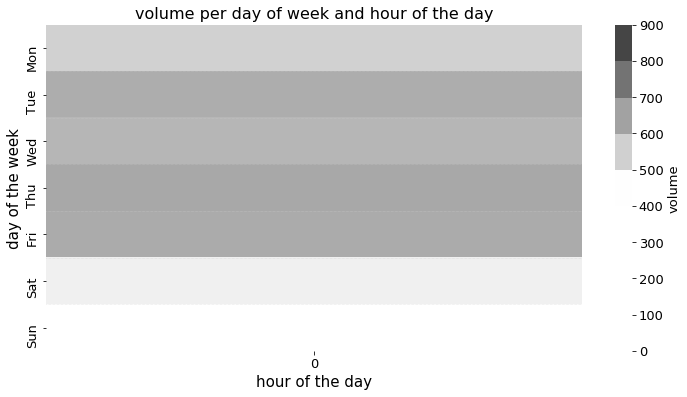

In [16]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=1000, cbar_kws={'boundaries':np.arange(0,1000,100)})
cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('volume', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('volume per day of week and hour of the day', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

In [17]:
weekdays = dfc.loc[dfc.index.strftime('%A').isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'volume, filtered']
weekends = dfc.loc[dfc.index.strftime('%A').isin(['Saturda', 'Sunday']), 'volume, filtered']
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

Text(0.5, 1.0, 'current volume per hour of the day')

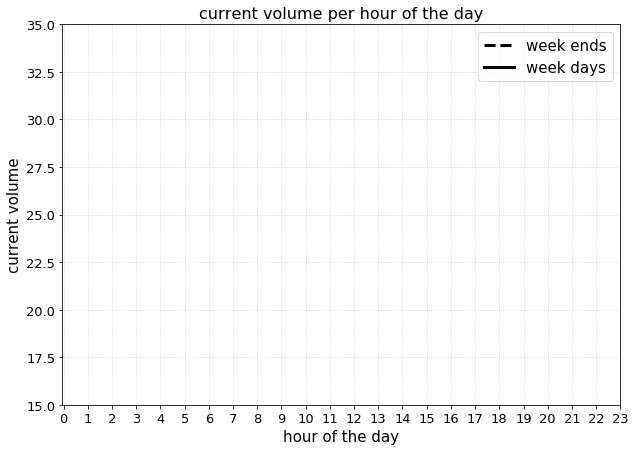

In [18]:
f, ax = plt.subplots(figsize = (10,7))
ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='|||||', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([15, 35])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('current volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('current volume per hour of the day', fontsize=16)

In [19]:
data = dfc.loc[:, ['volume, filtered']].resample('1440Min').mean()
data

,"volume, filtered"
timestamp,
2018-04-28,389.0
2018-04-29,389.0
2018-04-30,293.0
2018-05-01,293.0
2018-05-02,456.0
...,...
2020-01-31,476.0
2020-02-01,325.0
2020-02-02,325.0


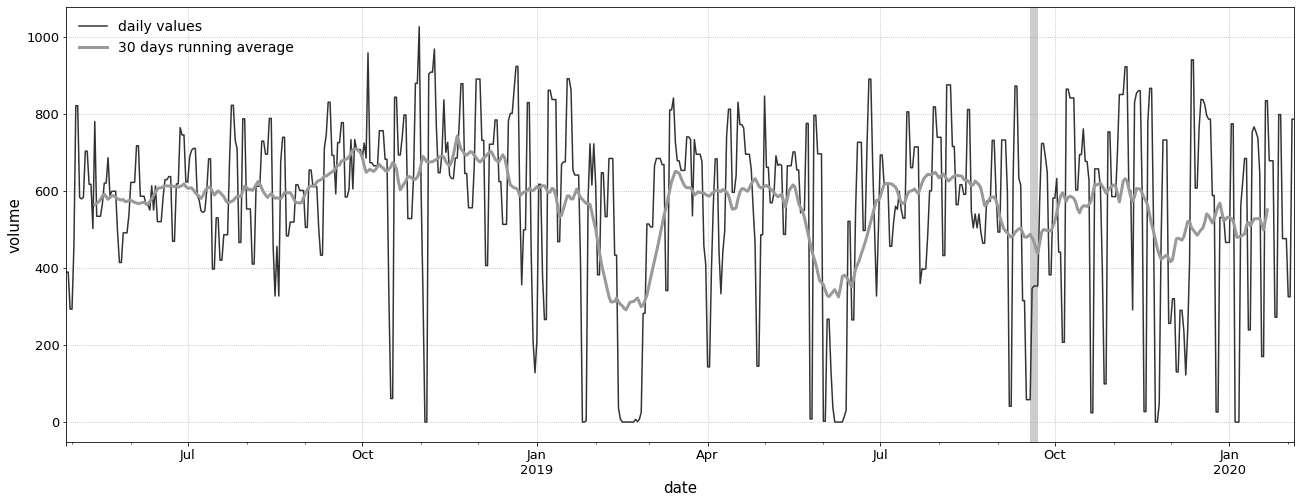

In [20]:
f, ax = plt.subplots(figsize=(22,8))
data.plot(ax=ax, color = '0.2')
data.rolling(window = 30, center = True).mean().plot(ax=ax, ls = '-', lw = 3, color = '0.6')
ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('volume', fontsize=15);

ax.axvline('20/09/2019', color='0.8', lw=8, zorder=-1)

In [21]:
data_train = data[data.index <'2019-09-20']
data_train = data_train.reset_index()
data_train = data_train.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train

,ds,y
0,2018-04-28,389.0
1,2018-04-29,389.0
2,2018-04-30,293.0
3,2018-05-01,293.0
4,2018-05-02,456.0
...,...,...
505,2019-09-15,315.0
506,2019-09-16,58.0
507,2019-09-17,58.0
508,2019-09-18,58.0


In [22]:
data_test = data[data.index > '2019-09-20']
data_test = data_test.reset_index()
data_test = data_test.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test

,ds,y
0,2019-09-21,353.0
1,2019-09-22,353.0
2,2019-09-23,575.0
3,2019-09-24,723.0
4,2019-09-25,723.0
...,...,...
132,2020-01-31,476.0
133,2020-02-01,325.0
134,2020-02-02,325.0
135,2020-02-03,786.0


In [23]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [24]:
m.fit(data_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [25]:
future = m.make_future_dataframe(periods=len(data_test), freq='24H')

In [26]:
future.head()

,ds
0,2018-04-28
1,2018-04-29
2,2018-04-30
3,2018-05-01
4,2018-05-02


In [27]:
future.tail()

,ds
642,2020-01-30
643,2020-01-31
644,2020-02-01
645,2020-02-02
646,2020-02-03


In [28]:
forecast = m.predict(future)

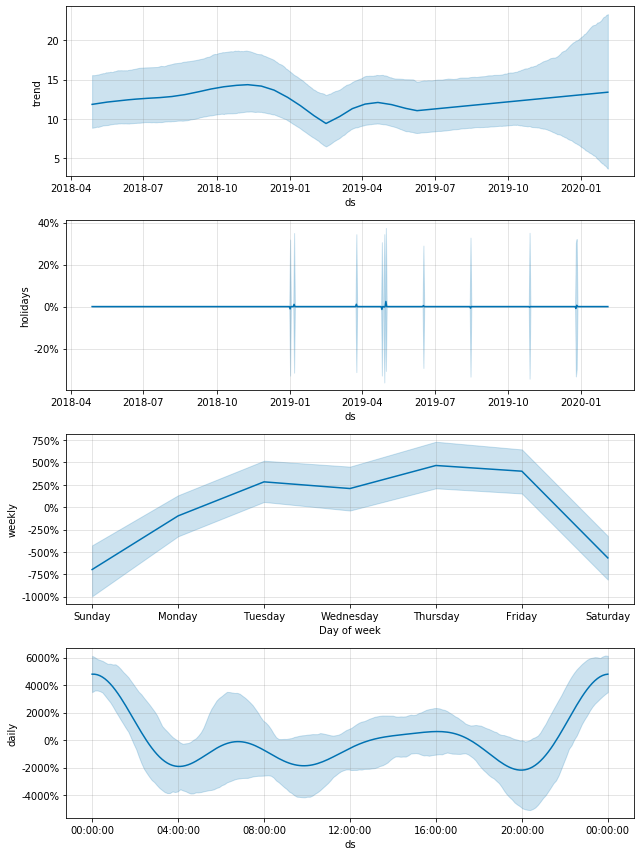

In [29]:
f = m.plot_components(forecast)

In [30]:
verif = utils.make_verif(forecast, data_train, data_test)

In [31]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28,2018-04-28,11.842818,198.129354,758.225822,8.856038,15.574699,0.0,0.0,0.0,0.0,...,30.868127,53.434909,-5.669278,-8.103651,-3.217032,0.0,0.0,0.0,512.452796,389.0
2018-04-29,2018-04-29,11.858982,205.906171,724.327782,8.881539,15.565789,0.0,0.0,0.0,0.0,...,29.180504,52.140914,-6.967563,-9.958214,-4.264079,0.0,0.0,0.0,497.755886,389.0
2018-04-30,2018-04-30,11.875146,280.492629,811.586117,8.897983,15.553384,0.0,0.0,0.0,0.0,...,34.185711,59.335858,-0.972774,-3.255665,1.328629,0.0,0.0,0.0,569.623333,293.0
2018-05-01,2018-05-01,11.891310,327.806651,877.271098,8.914426,15.577437,0.0,0.0,0.0,0.0,...,36.417033,64.101877,2.834099,0.586576,5.198057,0.0,0.0,0.0,615.667395,293.0
2018-05-02,2018-05-02,11.907474,308.452128,849.341054,8.943972,15.575386,0.0,0.0,0.0,0.0,...,36.387120,64.465162,2.087617,-0.372684,4.535460,0.0,0.0,0.0,607.615564,456.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-30,2020-01-30,13.353593,139.825510,1269.414013,4.076612,23.020186,0.0,0.0,0.0,0.0,...,37.913828,67.600871,4.663053,2.110935,7.319698,0.0,0.0,0.0,715.799536,476.0
2020-01-31,2020-01-31,13.363431,145.576951,1237.679211,4.005503,23.092417,0.0,0.0,0.0,0.0,...,37.730376,66.127610,4.024845,1.534630,6.458966,0.0,0.0,0.0,707.798272,476.0
2020-02-01,2020-02-01,13.373270,82.619781,1062.586086,3.903772,23.235667,0.0,0.0,0.0,0.0,...,30.868127,53.434909,-5.669278,-8.103651,-3.217032,0.0,0.0,0.0,578.677244,325.0


# Train Set

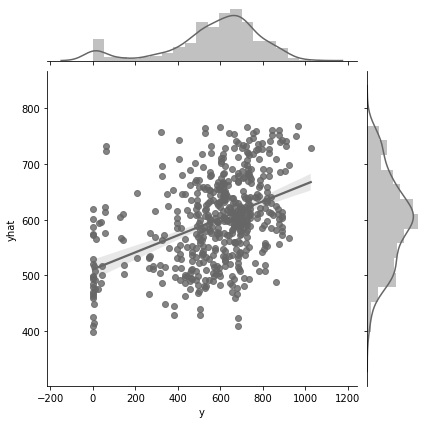

In [32]:
sns.jointplot('y', 'yhat',data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [33]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [34]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.421923
yhat,0.421923,1.000000


In [35]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

144.76277288702275

# Test Set

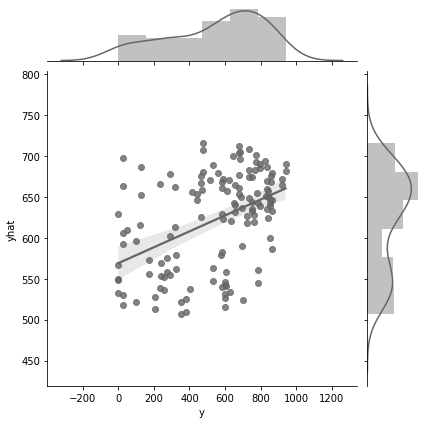

In [36]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')


In [37]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.444601
yhat,0.444601,1.000000


In [38]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

202.88218465739442

Text(0, 0.5, 'NORMALIZED FREQUENCY')

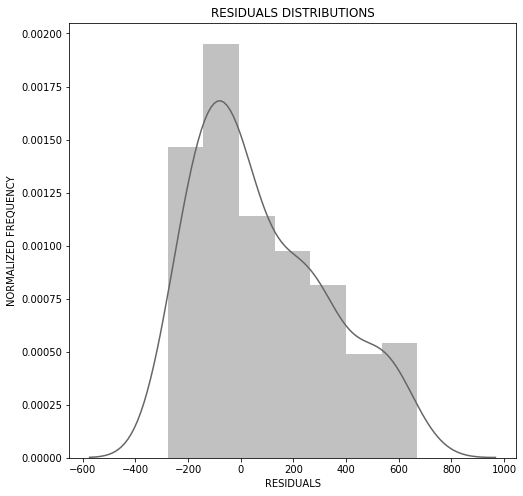

In [39]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [40]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

-0.633445138120859

In [41]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [42]:
residuals.median()

-9.986115701469146

In [43]:
residuals.mean()

-80.5455997850215

# Weather data

In [44]:
weather_data = aggregation_functionWeather(1440)

In [45]:
weather_data

,temperature,windSpeed,precipIntensity
timestamp,,,
2018-09-01,28.3,3.6,0.0
2018-09-02,27.9,4.3,0.0
2018-09-03,27.9,4.7,0.0
2018-09-04,27.6,9.5,0.0
2018-09-05,26.6,11.2,0.0
...,...,...,...
2020-02-20,9.8,8.9,0.0
2020-02-21,10.0,10.1,0.0
2020-02-22,9.4,12.7,0.0


In [46]:
weather_data = weather_data.loc[:, ['precipIntensity', 'temperature','windSpeed']]
weather_data

,precipIntensity,temperature,windSpeed
timestamp,,,
2018-09-01,0.0,28.3,3.6
2018-09-02,0.0,27.9,4.3
2018-09-03,0.0,27.9,4.7
2018-09-04,0.0,27.6,9.5
2018-09-05,0.0,26.6,11.2
...,...,...,...
2020-02-20,0.0,9.8,8.9
2020-02-21,0.0,10.0,10.1
2020-02-22,0.0,9.4,12.7


In [47]:
weather_data.corr()

,precipIntensity,temperature,windSpeed
precipIntensity,1.000000,-0.056474,0.167960
temperature,-0.056474,1.000000,-0.041557
windSpeed,0.167960,-0.041557,1.000000


In [48]:
data_all = (data.reset_index()).merge(weather_data, left_on = "timestamp", right_on = "timestamp")
data_all.rename

data_all.set_index('timestamp', inplace = True)

In [49]:
data_all.corr()

,"volume, filtered",precipIntensity,temperature,windSpeed
"volume, filtered",1.000000,-0.055492,0.021722,-0.157671
precipIntensity,-0.055492,1.000000,-0.061301,0.171918
temperature,0.021722,-0.061301,1.000000,-0.022451
windSpeed,-0.157671,0.171918,-0.022451,1.000000


In [50]:
data_all['temperature'] = data_all['temperature'].interpolate(method = 'linear')
data_all['precipIntensity'] = data_all['precipIntensity'].interpolate(method = 'linear')
data_all['windSpeed'] = data_all['windSpeed'].interpolate(method = 'linear')

In [51]:
data_all

,"volume, filtered",precipIntensity,temperature,windSpeed
timestamp,,,,
2018-09-01,505.0,0.0,28.3,3.6
2018-09-02,505.0,0.0,27.9,4.3
2018-09-03,654.0,0.0,27.9,4.7
2018-09-04,654.0,0.0,27.6,9.5
2018-09-05,611.0,0.0,26.6,11.2
...,...,...,...,...
2020-01-31,476.0,0.0,8.4,2.1
2020-02-01,325.0,0.0,12.0,2.5
2020-02-02,325.0,0.0,11.5,1.5


In [52]:
data_train_all = data_all[data_all.index < '2019-09-20']
data_train_all = data_train_all.reset_index()
data_train_all = data_train_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train_all.tail()

,ds,y,precipIntensity,temperature,windSpeed
379,2019-09-15,315.0,0.0,26.0,5.8
380,2019-09-16,58.0,0.0,24.3,4.7
381,2019-09-17,58.0,0.0,24.4,3.3
382,2019-09-18,58.0,0.0,25.1,3.5
383,2019-09-19,347.0,2.0,24.2,8.3


In [53]:
data_test_all = data_all[data_all.index >= '2019-09-20']
data_test_all = data_test_all.reset_index()
data_test_all = data_test_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test_all.tail()

,ds,y,precipIntensity,temperature,windSpeed
133,2020-01-31,476.0,0.0,8.4,2.1
134,2020-02-01,325.0,0.0,12.0,2.5
135,2020-02-02,325.0,0.0,11.5,1.5
136,2020-02-03,786.0,0.0,11.1,1.4
137,2020-02-04,786.0,0.0,13.1,4.2


In [54]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [55]:
m.add_regressor('precipIntensity', prior_scale = 0.5, mode = 'additive')
m.add_regressor('temperature', prior_scale = 0.5, mode = 'additive')
m.add_regressor('windSpeed', prior_scale = 0.5, mode = 'additive')

In [56]:
m.fit(data_train_all)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [57]:
future = m.make_future_dataframe(periods = len(data_test_all), freq = '24H')

In [58]:
future.head()

,ds
0,2018-09-01
1,2018-09-02
2,2018-09-03
3,2018-09-04
4,2018-09-05


In [59]:
future.tail()

,ds
517,2020-01-31
518,2020-02-01
519,2020-02-02
520,2020-02-03
521,2020-02-04


In [60]:
futures = (future).merge(data_all[['precipIntensity', 'temperature', 'windSpeed']], left_on = "ds", right_on = "timestamp")

In [61]:
forecast = m.predict(futures)

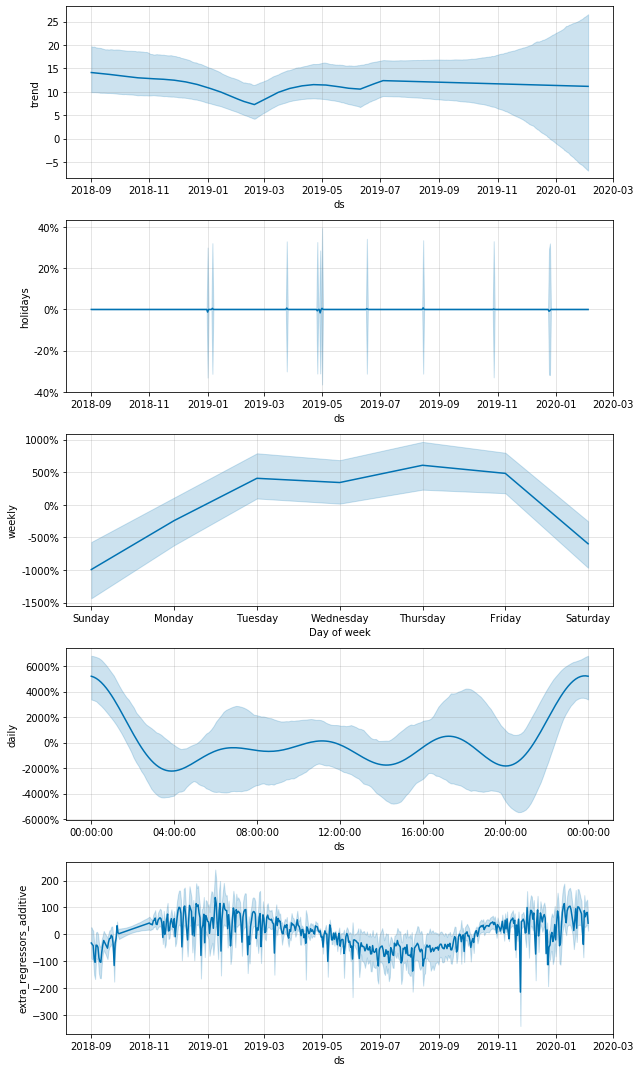

In [62]:
f = m.plot_components(forecast)

In [63]:
verif = utils.make_verif(forecast, data_train_all, data_test_all)

In [64]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,temperature_lower,temperature_upper,weekly,weekly_lower,weekly_upper,windSpeed,windSpeed_lower,windSpeed_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-09-01,2018-09-01,14.115098,307.969084,865.276388,9.896681,19.747480,0.0,0.0,0.0,0.0,...,-113.918195,2.790281,-5.981458,-9.663150,-2.537339,21.505374,10.963796,32.292053,631.983251,505.0
2018-09-02,2018-09-02,14.095249,247.836505,812.914816,9.924639,19.632752,0.0,0.0,0.0,0.0,...,-109.632451,2.685307,-9.929981,-14.340697,-5.711762,14.090964,7.183807,21.158719,570.083430,505.0
2018-09-03,2018-09-03,14.075401,351.678116,910.143218,9.914298,19.624676,0.0,0.0,0.0,0.0,...,-109.632451,2.685307,-2.430409,-6.206575,1.099219,9.854159,5.023813,14.796814,670.550976,654.0
2018-09-04,2018-09-04,14.055552,377.864649,946.341706,9.915617,19.657798,0.0,0.0,0.0,0.0,...,-106.418143,2.606577,4.057205,0.964436,7.892919,-40.987508,-61.546048,-20.896110,711.469940,654.0
2018-09-05,2018-09-05,14.035703,345.146269,934.782756,9.923528,19.564413,0.0,0.0,0.0,0.0,...,-95.703784,2.344142,3.411722,0.177248,6.842456,-58.993931,-88.584144,-30.076083,688.529736,611.0


# Train Set

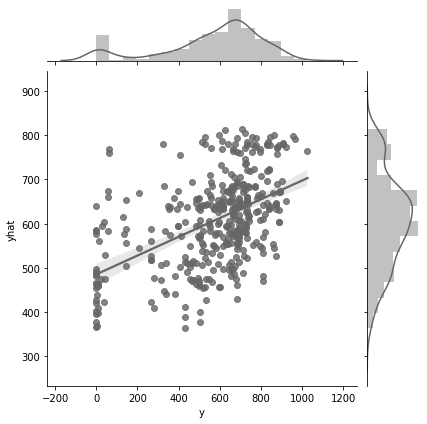

In [65]:
sns.jointplot('y', 'yhat', data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [66]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,temperature_lower,temperature_upper,weekly,weekly_lower,weekly_upper,windSpeed,windSpeed_lower,windSpeed_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [67]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.497031
yhat,0.497031,1.000000


In [68]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

155.6522586570953

In [69]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

155.6522586570953

# Test Set

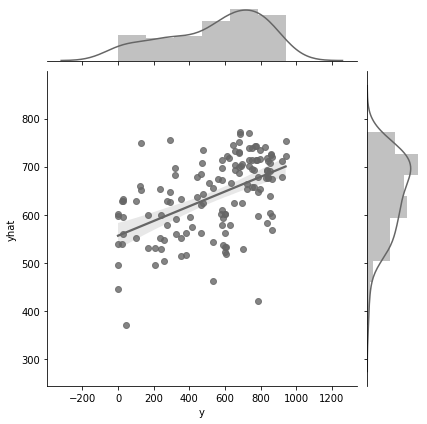

In [70]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')

In [71]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.506831
yhat,0.506831,1.000000


In [72]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

195.5721341881771

Text(0, 0.5, 'NORMALIZED FREQUENCY')

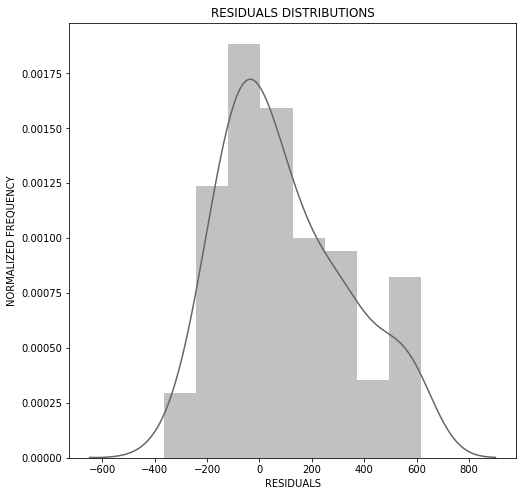

In [73]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [74]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

-0.5533166450871589

In [75]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [76]:
residuals.median()

-34.8797870690002

In [77]:
residuals.mean()

-97.86361372437646

In [78]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,temperature_lower,temperature_upper,weekly,weekly_lower,weekly_upper,windSpeed,windSpeed_lower,windSpeed_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-09-01,2018-09-01,14.115098,307.969084,865.276388,9.896681,19.747480,0.0,0.0,0.0,0.0,...,-113.918195,2.790281,-5.981458,-9.663150,-2.537339,21.505374,10.963796,32.292053,631.983251,505.0
2018-09-02,2018-09-02,14.095249,247.836505,812.914816,9.924639,19.632752,0.0,0.0,0.0,0.0,...,-109.632451,2.685307,-9.929981,-14.340697,-5.711762,14.090964,7.183807,21.158719,570.083430,505.0
2018-09-03,2018-09-03,14.075401,351.678116,910.143218,9.914298,19.624676,0.0,0.0,0.0,0.0,...,-109.632451,2.685307,-2.430409,-6.206575,1.099219,9.854159,5.023813,14.796814,670.550976,654.0
2018-09-04,2018-09-04,14.055552,377.864649,946.341706,9.915617,19.657798,0.0,0.0,0.0,0.0,...,-106.418143,2.606577,4.057205,0.964436,7.892919,-40.987508,-61.546048,-20.896110,711.469940,654.0
2018-09-05,2018-09-05,14.035703,345.146269,934.782756,9.923528,19.564413,0.0,0.0,0.0,0.0,...,-95.703784,2.344142,3.411722,0.177248,6.842456,-58.993931,-88.584144,-30.076083,688.529736,611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,2020-01-31,11.182160,-328.875062,1524.637278,-6.094461,25.967805,0.0,0.0,0.0,0.0,...,-2.432167,99.297558,4.815085,1.770659,7.977897,37.393395,19.063772,56.149197,735.310370,476.0
2020-02-01,2020-02-01,11.176459,-273.770883,1256.640198,-6.286831,26.081515,0.0,0.0,0.0,0.0,...,-1.487403,60.725864,-5.981458,-9.663150,-2.537339,33.156589,16.903778,49.787292,591.145160,325.0
2020-02-02,2020-02-02,11.170758,-279.520961,1208.589718,-6.479202,26.232061,0.0,0.0,0.0,0.0,...,-1.618620,66.083044,-9.929981,-14.340697,-5.711762,43.748603,22.303762,65.692055,559.990449,325.0


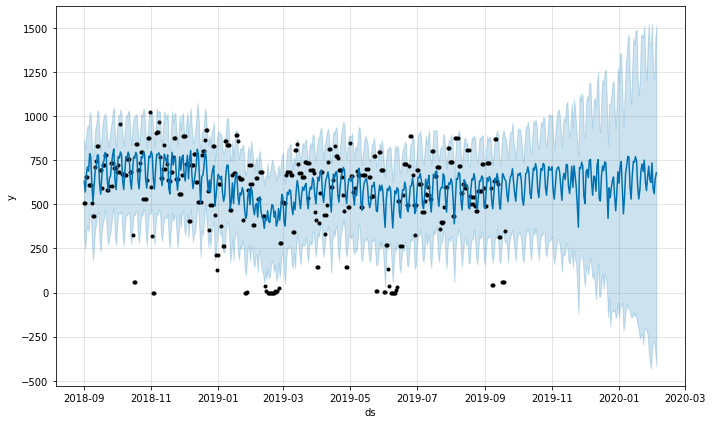

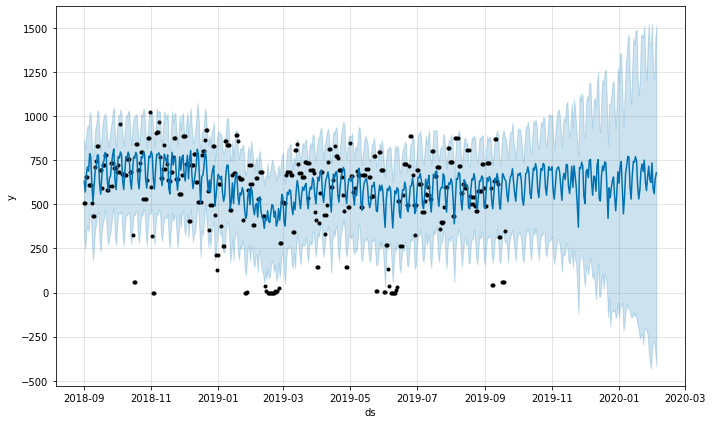

In [79]:
m.plot(forecast)

Text(0, 0.5, 'Volume')

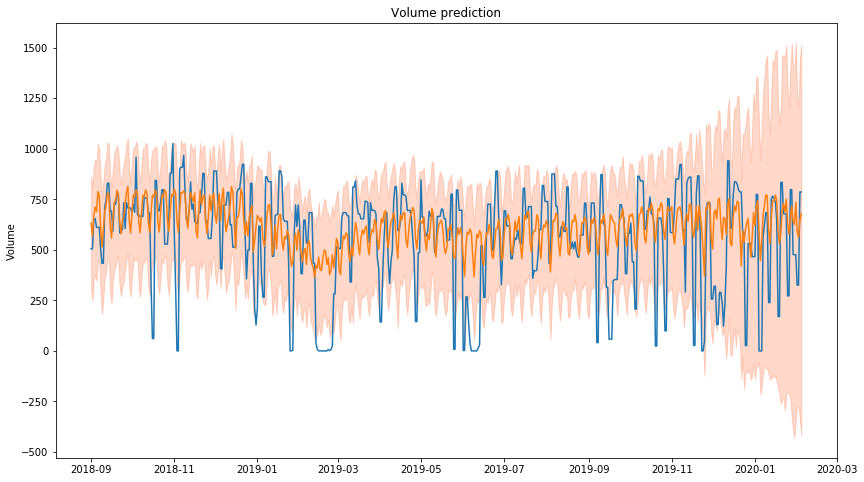

In [80]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(verif.index, verif['y'], label = 'True values')
ax.plot(verif.index, verif['yhat'], label = 'Predicted values')
ax.set_title("Volume prediction")
ax.fill_between(verif.index, verif.loc[:, 'yhat_lower'], verif.loc[:, 'yhat_upper'], color = 'coral', alpha = 0.3)
plt.ylabel("Volume")

# Correlaciones diarias

In [81]:
corr = verif.loc[:, ['y', 'yhat']].rolling(window = 1000).corr()

In [82]:
corr.index = corr.index.droplevel(1)

Text(0.5, 1.0, 'Correlaciones con media rodante de 1000 períodos')

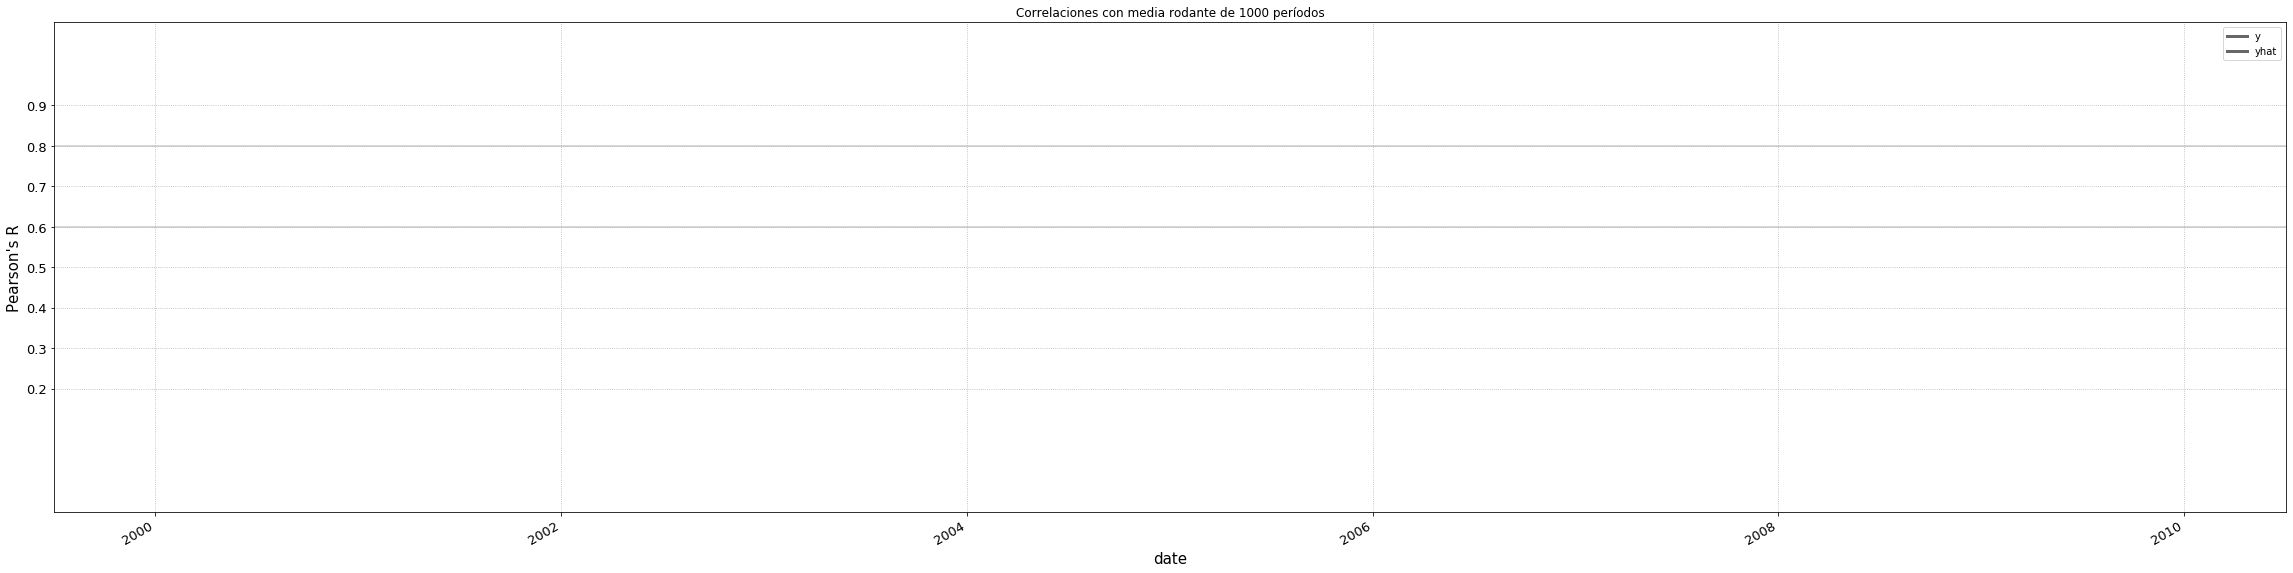

In [83]:
fig, ax = plt.subplots(figsize = (40,10))
corr.plot(ax=ax, lw = 3, color = '0.4')
ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.grid(ls=':')
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.2, 1., 0.1)); 
ax.set_title('Correlaciones con media rodante de 1000 períodos')


Mucha variabilidad en los datos a lo largo del día, con mucho porcentaje aleatorio que Prophet no es capaz de predecir. 

# Correlaciones por mes

In [84]:
corr_season_train = verif.loc[:'2019-09-20', ['y', 'yhat']].groupby(verif.loc[:'2019-09-20', :].index.month).corr()
corr_season_test = verif.loc['2019-09-20':, ['y', 'yhat']].groupby(verif.loc['2019-09-20':, :].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

Text(0.5, 1.0, 'Correlation per month')

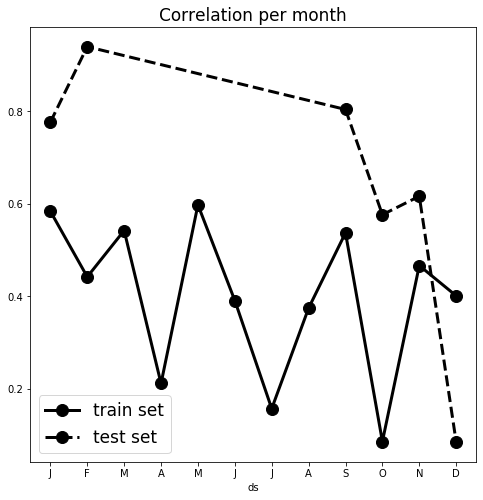

In [85]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set', ls='-', color='k')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='test set', ls='--', color='k')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_title('Correlation per month', fontsize=17)